## Carregamento do dataset, merge dos dados dos prontuários e rename de colunas

In [ ]:
import pandas as pd
import numpy as np

from datetime import date, datetime
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# df = pd.read_csv('prontuario-controle-usuarios-v02.csv')

path_prontuarios = 'prontuario-controle-usuarios-v02.csv'
path_agenda_ajustada = 'agenda-ajustado-v04-dados-cer.csv'

prontuarios1 = pd.read_csv(path_agenda_ajustada)
prontuarios2 = pd.read_csv(path_prontuarios)

prontuarios = pd.merge(prontuarios1, prontuarios2, how='left', on=['num_prontuario'])

Removidos (agenda.csv):
* Coluna "num_prontuario" (merge com o prontuário do paciente:
  * 9 registros com valores inválidos ou vazios. Exemplo: "12:10", "17/9/1902", "825/982", "639/592", "639/592")


# Dados Brutos

## Dados dos prontuários

In [ ]:
print('%d prontuários brutos para análise' % len(prontuarios))

49759 prontuários brutos para análise


In [ ]:
prontuarios.columns

Index(['num_prontuario', 'especialidade ', 'horario', 'genero', 'data',
       'compareceu', 'justificativa', 'DEF.', 'DATA DE NASCIMENTO',
       'DATA ENTRADA no Serviço', 'PROCEDÊNCIA', 'CID', 'UBS'],
      dtype='object')

In [ ]:
prontuarios.shape

(49759, 13)

In [ ]:
rename = {
    'especialidade ': 'especialidade',
    'data': 'data_consulta',
    'DEF.' : 'deficiencia',
    'DATA DE NASCIMENTO' : 'data_nascimento',
    'DATA ENTRADA no Serviço' : 'data_entrada_servico',
    'PROCEDÊNCIA' : 'cidade_procedencia',
    'CID' : 'cid',
    'UBS' : 'ubs',
}
dados = prontuarios.rename(columns=rename)
dados.columns

Index(['num_prontuario', 'especialidade', 'horario', 'genero', 'data_consulta',
       'compareceu', 'justificativa', 'deficiencia', 'data_nascimento',
       'data_entrada_servico', 'cidade_procedencia', 'cid', 'ubs'],
      dtype='object')

# Data Wrangling

## Dados da agenda

### Dados faltantes SEM PRÉ-PROCESSAMENTO

In [ ]:
# Porcentagem dos valores faltantes por coluna

for column in dados.columns:
    if dados[column].isnull().sum() > 0:
        print(column, ': {:.2%}'.format(dados[column].isnull().sum() /
                                               dados[column].shape[0]))

especialidade : 0.07%
horario : 0.03%
genero : 0.01%
compareceu : 0.10%
justificativa : 82.78%
deficiencia : 10.12%
data_nascimento : 20.26%
data_entrada_servico : 10.16%
cidade_procedencia : 10.18%
cid : 79.91%
ubs : 81.45%


### Coluna "Compareceu"

In [ ]:
dados.compareceu.value_counts()

Sim            41388
Não             4035
não informa     2110
Sim             1398
não              264
Não              204
sim              199
???               64
Nao               31
NÃO                9
SIm                6
NAo                1
N                  1
Name: compareceu, dtype: int64

In [ ]:
dados = dados[(dados.compareceu != 'não informa') & (dados.compareceu != '???')]
print(dados['compareceu'].value_counts())

Sim     41388
Não      4035
Sim      1398
não       264
Não       204
sim       199
Nao        31
NÃO         9
SIm         6
NAo         1
N           1
Name: compareceu, dtype: int64


In [ ]:
# Replace de dados incorretos coluna attended
dados.loc[dados['compareceu'].isin(['Não', 'Não ', 'não', 'NAo', 'Nao', 'N', 'NÃO']), 'compareceu'] = 'Não'
dados.loc[dados['compareceu'].isin(['Sim', 'Sim ', 'sim', 'SIm']), 'compareceu'] = 'Sim'

print(dados['compareceu'].value_counts())

Sim    42991
Não     4545
Name: compareceu, dtype: int64


In [ ]:
dados['compareceu'].unique()

array(['Não', 'Sim', nan], dtype=object)

In [ ]:
dados['compareceu'].isna().sum()

49

### Coluna "Gênero"

In [ ]:
dados.genero.value_counts()

M             32754
F             10767
m              2639
M               724
f               670
sem nome          5
Indefinido        4
N                 4
F                 4
         F        3
"Orli"            2
i                 2
D                 1
I                 1
Name: genero, dtype: int64

In [ ]:
dados['genero'].unique()

array(['M', 'F', 'f', 'm', 'sem nome', 'M ', 'Indefinido', 'i', nan, 'N',
       'I', 'F ', 'D', '         F', '"Orli"'], dtype=object)

In [ ]:
dados['genero'].nunique()

14

In [ ]:
# Replace de dados incorretos coluna attended
dados.loc[dados['genero'].isin(['M', 'M ', 'm', 'NAo', 'Nao', 'N', 'NÃO']), 'genero'] = 'M'
dados.loc[dados['genero'].isin(['F', 'F ', 'f', '         F', '']), 'genero'] = 'F'
dados.loc[dados['genero'].isin(['Indefinido', 'i', 'I']), 'genero'] = 'I'

print(dados['genero'].value_counts())

M           36121
F           11444
I               7
sem nome        5
"Orli"          2
D               1
Name: genero, dtype: int64


In [ ]:
dados = dados[(dados.genero == 'M') | (dados.genero == 'F') | (dados.genero == 'I')]
print(dados['genero'].value_counts())

M    36121
F    11444
I        7
Name: genero, dtype: int64


In [ ]:
dados['genero'].isna().sum()

0

### Coluna "Especialidade"

Valores considerados:
* Psico- Psicologo
* Fono- Fonodiologo
* Nutri-Nutricionista
* TO-Terapia Ocupacional
* Pedago-Pedagogo
* Fisio- Fisioterapia
* Assist- Assistente Social

In [ ]:
dados['especialidade'] = dados['especialidade'].str.strip().str.lower()

In [ ]:
dados.especialidade.value_counts()

psico                11426
fono                 11190
fisio                 8779
to                    6022
nutri                 1683
                     ...  
luis                     1
pscio                    1
pisco                    1
`psico                   1
cristiane / julia        1
Name: especialidade, Length: 77, dtype: int64

In [ ]:
dados.loc[dados['especialidade'].isin(['psico', 'pisco', '`psico', 'pscio', 'psico 2', 'psico 1']), 'especialidade'] = 'psico'
dados.loc[dados['especialidade'].isin(['fono', 'f', 'fono1', 'fono2', 'fono 1', 'fono 2']), 'especialidade'] = 'fono'
dados.loc[dados['especialidade'].isin(['assist', 'a.s', 'as']), 'especialidade'] = 'assist'
dados.loc[dados['especialidade'].isin(['fisio', 'fisio 1', 'fisio 2', 'fiso']), 'especialidade'] = 'fisio'
dados.loc[dados['especialidade'].isin(['to', 't.o.', 't.o']), 'especialidade'] = 'terap_ocupacional'
dados.loc[dados['especialidade'].isin(['pedago', 'pedagoga', 'pedag']), 'especialidade'] = 'pedagogo'

#### Conversão do nome do especialista para o label "especialista"



- [ ] Solicitar para o Rafael o mapeamento do nome do especialista -> especialidade

In [ ]:
dados.loc[~dados['especialidade'].isin(['psico', 'fono', 'assist', 'fisio', 'terap_ocupacional', 'pedagogo', 'sem especialidade', 'enf']), 'especialidade'] = 'especialista'

In [ ]:
dados['especialidade'].unique()

array(['fisio', 'psico', 'fono', 'terap_ocupacional', 'especialista',
       'enf', 'assist', 'pedagogo', 'sem especialidade'], dtype=object)

In [ ]:
dados['especialidade'].value_counts()

fono                 11653
psico                11591
fisio                 8894
terap_ocupacional     6441
especialista          5967
pedagogo              2066
enf                    709
assist                 194
sem especialidade       57
Name: especialidade, dtype: int64

In [ ]:
dados['especialidade'].isna().sum()

0

### Coluna "Data da Consulta"

* Criação da coluna **mês** e **ano** da consulta
* Criação da coluna **idade**

In [ ]:
def convert_data_zero_esquerda(data):
  try:
    data_original = datetime.strptime(data, '%d/%m/%Y').date()
    data_formatada = data_original.strftime('%d/%m/%Y')
    return data_formatada
  except ValueError:
    print(data)
    raise ValueError("Incorrect data format, should be YYYY-MM-DD")

dados['data_consulta'] = dados.data_consulta.apply(convert_data_zero_esquerda)

#### Criação da coluna de **mês e ano** da consulta


In [ ]:
from datetime import datetime
from datetime import date
import numpy as np

MONTHS = {1: 'jan', 2: 'fev', 3: 'mar', 4: 'abr', 5: 'maio', 6: 'jun',
          7: 'jul', 8: 'ago', 9: 'set', 10: 'out', 11: 'nov', 12: 'dez'}

def extrai_appointment_month(data):
    try:
      data = datetime.strptime(data, "%d/%m/%Y").date()
      return MONTHS[data.month]
    except ValueError as err:
      print('Data com formato inválido: ' + data)
      pass

dados['mes_consulta'] = dados['data_consulta'].apply(extrai_appointment_month)

In [ ]:
def extrai_appointment_year(data):
    try:
      data = datetime.strptime(data, "%d/%m/%Y").date()
      return data.year
    except ValueError as err:
      print('Data com formato inválido: ' + data)
      pass

dados['ano_consulta'] = dados['data_consulta'].apply(extrai_appointment_year)

In [ ]:
dados.ano_consulta.value_counts()

2017    12591
2018     9606
2019     8584
2016     8007
2021     6917
2022      963
2020      904
Name: ano_consulta, dtype: int64

#### Plot dos dados

Primeiro, salientar no texto que os plots foram gerados para validar que o montante de dados digitalizados (incluídos nas planilhas) está de acordo com o esperado pelo especialista da CER (Prof. Rafael). Ou seja, objetivo da visualização por ano foi validar que faz sentido com os dados da clínica.


Salientar aqui que o ano de 2022 foi removido para analisar os dados posteriormente. Os dados de 2020 também será reanalisados para validar possíveis erros de digitação.

##### Remoção dados de 2022 e groupby mês/ano para os plots

In [ ]:
dados_ate_2021 = dados[pd.to_datetime(dados['data_consulta']).dt.year != 2022]

In [ ]:
df = dados_ate_2021
dados_data_consulta_por_mes_ano = df['data_consulta'].groupby([pd.to_datetime(df['data_consulta']).dt.year.rename('ano'), pd.to_datetime(df['data_consulta']).dt.month.rename('mês')]).agg({'count'})

##### **(Não utilizado no relatório)** Teste de plot com os meses e não via número do mês -> jan: 1, fev: 2, etc

In [ ]:
#df = dados_ate_2021
#teste = df['data_consulta'].groupby([df['ano_consulta'], df['mes_consulta']]).agg({'count'})

In [ ]:
#import seaborn as sns
#sns.set_theme(style="darkgrid")
#plt.figure(figsize=(12,10))

#sns.lineplot(x="mes_consulta", y="count", hue="ano_consulta", palette='crest',
#             data=teste,
#             marker='o')

##### Plots

<AxesSubplot: xlabel='mês', ylabel='count'>

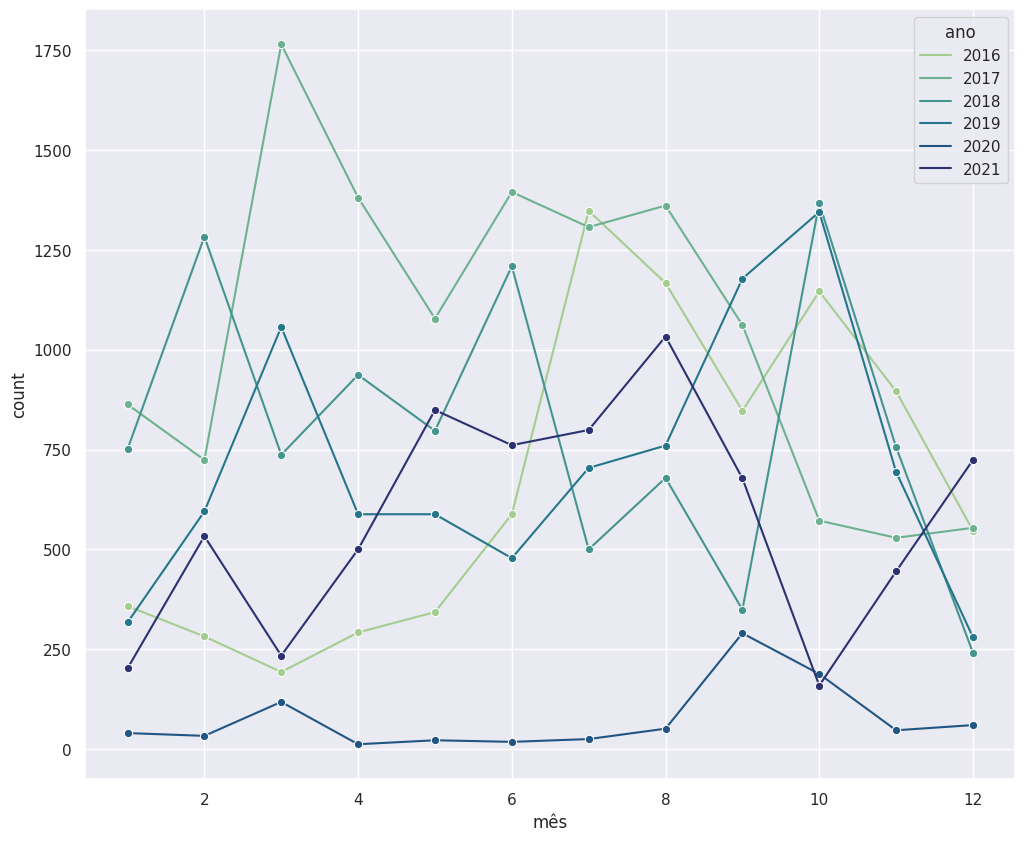

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
plt.figure(figsize=(12,10))

sns.lineplot(x="mês", y="count", hue="ano", palette='crest',
             data=dados_data_consulta_por_mes_ano,
             marker='o')

<Figure size 2000x1800 with 0 Axes>

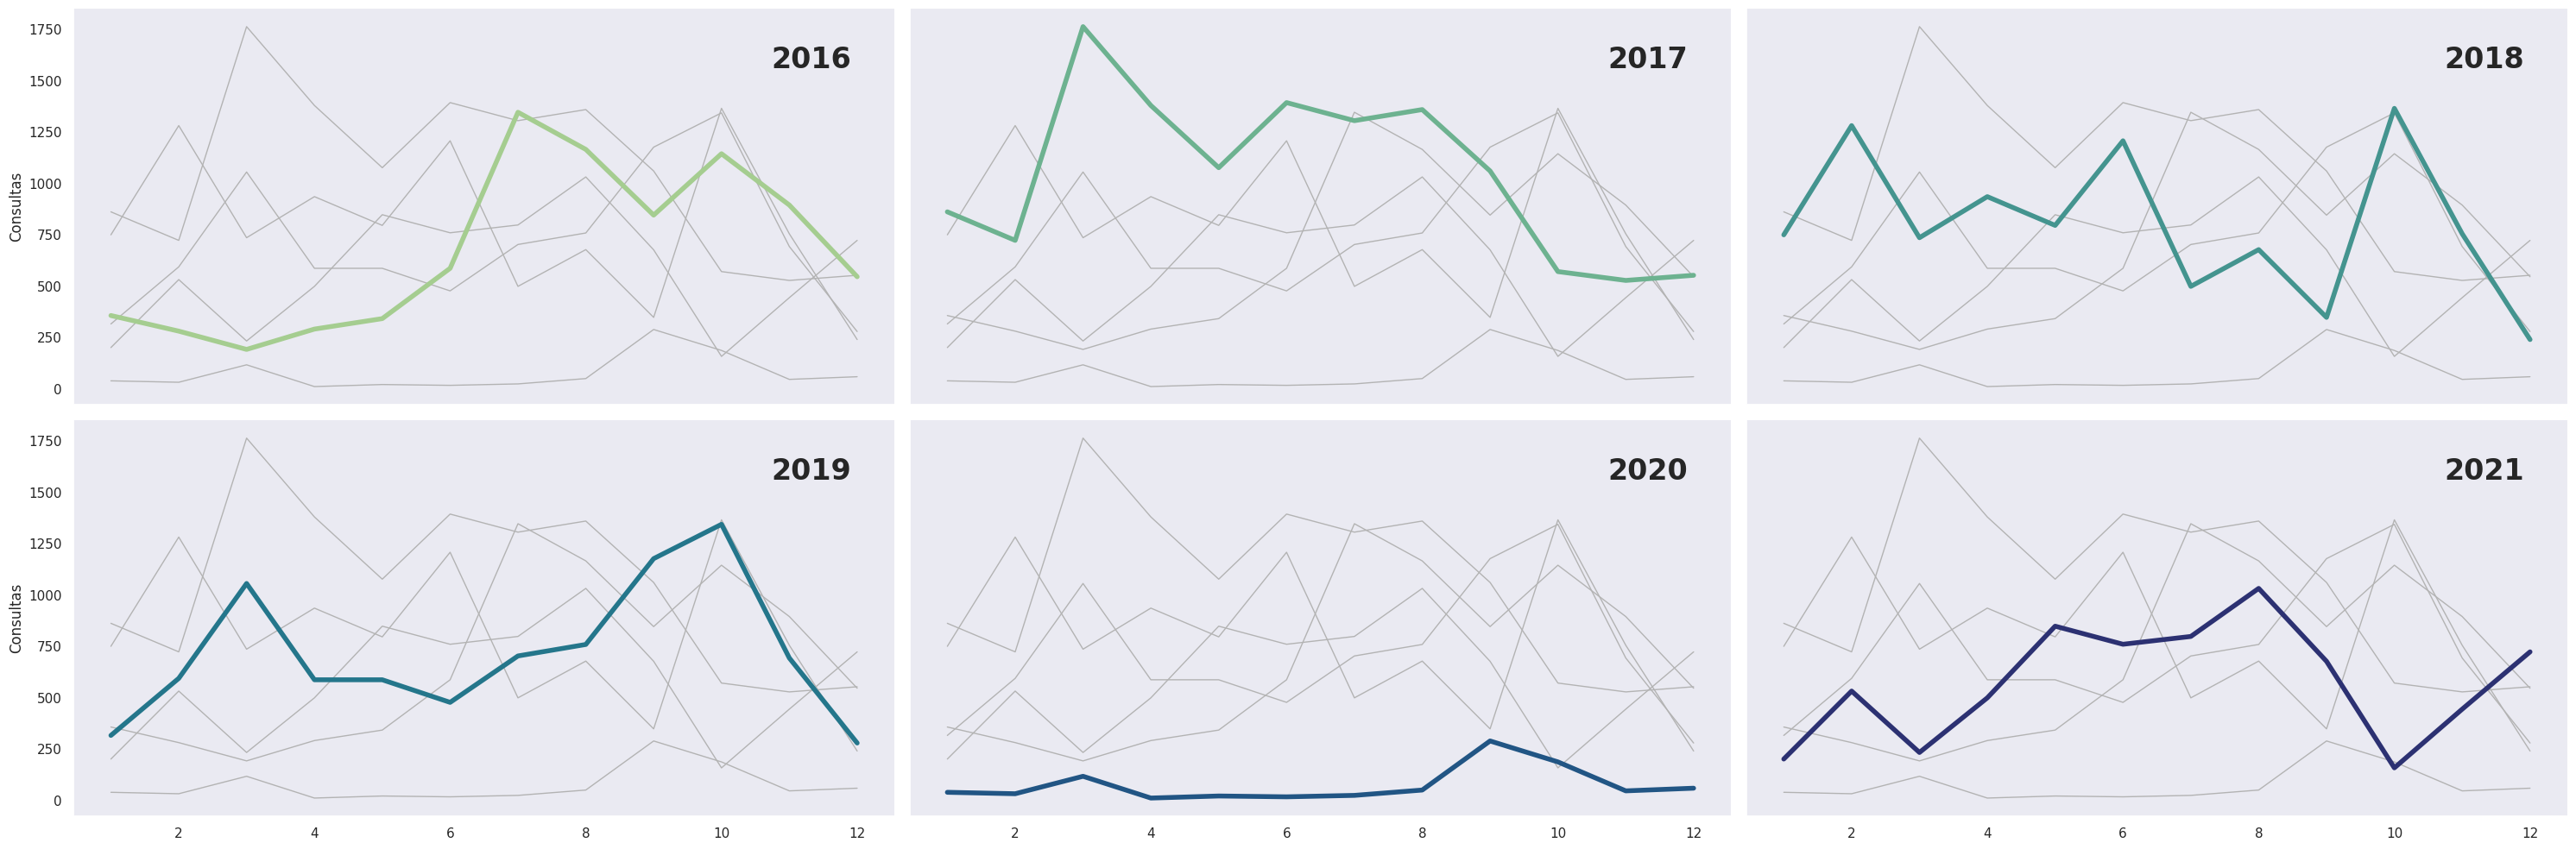

In [ ]:
import seaborn as sns

plt.figure(figsize=(20,18))

sns.set_theme(style="dark")
flights = dados_data_consulta_por_mes_ano

# Plot each year's time series in its own facet
# O "height" basicamente irá alterar a altura do seu gráfico e o "aspect" a largura.
g = sns.relplot(
    data=flights,
    x="mês", y="count", col="ano", hue="ano",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=5, aspect=2, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.85, .85, year, transform=ax.transAxes, fontweight="bold", fontsize=24)

    # Plot every year's time series in the background
    sns.lineplot(
        data=flights, x="mês", y="count", units="ano",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
#ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Consultas")
g.tight_layout()

In [ ]:
dados['data_consulta'].isna().sum()

0

### Coluna "Horário"

In [ ]:
dados['horario'] = dados['horario'].str.strip()

In [ ]:
dados.horario.unique()

array(['13:20', '14:00', '14:40', '15:20', '16:20', '17:00', '17:40',
       '08:00', '08:50', '09:40', '10:50', '11:40', '07:00', '08:40',
       '09:30', '10:20', '13:00', '16:35', '13:50', '15:30', '18:15',
       '17:25', '14:50', '15:40', '17:20', '08:20', '09:10', '10:30',
       '11:20', '07:30', '07:20', '09:20', '11:00', '18:00', '07:50',
       '12:20', '16:30', '11:10', '12:00', '13:30', '16:00', '08:30',
       '13:15', '15:50', '09:45', '10:35', '10:00', '09:50', '13:05',
       '12:10', '09:00', '11:30', '13:10', '13:40', '16:15', '15:10',
       '17:10', '14:20', '16:40', '14:30', '15:15', '10:10', nan, '08:10',
       '10:40', '16:36', '17:36', '15:00', '17:15', '14:10', '16:10',
       '17:35', '16:50', '09:03', '18:20'], dtype=object)

In [ ]:
dados['horario'].isna().sum()

17

#### Criação da coluna de "turno" (com base no horário)

In [ ]:
# Inclusão de "h" ao invés do ":" no horário
# ----- Não é usado para nada até o momento

#dados['horario_com_h'] = dados['horario'].replace(':','h', regex=True)
#dados.horario_com_h.unique()

##### Conversão de horário para datetime para extração da hora e popular a coluna de turno da consulta

In [ ]:
 # Converte horário para datetime
dados['horario_dt'] = pd.to_datetime(dados['horario'])

In [ ]:
# Cria turno com base no horário da consulta
def create_turno(appointment_time):
  return 'Manhã' if appointment_time.hour <= 12 else 'Tarde'

dados['turno_consulta'] = dados.horario_dt.apply(create_turno)

In [ ]:
dados.groupby('turno_consulta', axis=0)[['horario', 'turno_consulta']].head()

,horario,turno_consulta
0,13:20,Tarde
1,13:20,Tarde
2,13:20,Tarde
3,13:20,Tarde
4,14:00,Tarde
92,08:00,Manhã
93,08:50,Manhã
94,09:40,Manhã
95,08:00,Manhã
96,08:00,Manhã


### Coluna "Justificativa"

In [ ]:
dados.justificativa.value_counts()

Não                    4430
não justificada         460
Sim                     380
OK                      298
Não justificada         223
                       ... 
Dentista                  1
ida ao hospital           1
Mãe foi viajar            1
Dificuldade horário       1
sem carona                1
Name: justificativa, Length: 415, dtype: int64

In [ ]:
dados['justificativa'] = dados['justificativa'].str.strip().str.lower()

In [ ]:
print("Total de registros COM JUSTIFICATIVA de não comparecimento (sem ajustes): %d" % dados.justificativa.notna().sum())
print("Valores únicos de justificativa (sem ajustes): %d" % dados.justificativa.nunique())

Total de registros COM JUSTIFICATIVA de não comparecimento (sem ajustes): 8467
Valores únicos de justificativa (sem ajustes): 348


In [ ]:
# Valores anulados pois não fazem sentido
# “não” (4430), “não justificada” (847), “sim” (380), “ok” (298), “falta justificada” (258),
# “sem justificativa” (247), “não justificou” (50), “justificou” (38), “em branco” (26),
# “avisado” (13), “nao justificou” (9), “ok pts” (6), “sem justificariva” (6), “s/ justificativa” (6),
# “justificada” (5), “ok cancelar” (4), “cancelado” (3), “n” (3), “ilegível” (2), “ok vó” (2), “??” (1),
# “não justi:” (1), “f” (1), “ok ligar vô” (1)
anulaveis = ['não', 'não justificada', 'sim', 'ok', 'falta justificada', 'sem justificativa', 'não justificou',
             'justificou', 'em branco', 'avisado', 'nao justificou', 'ok pts', 'sem justificariva', 's/ justificativa',
             'justificada', 'ok cancelar', 'cancelado', 'n', 'ilegível', 'ok vó', '??', 'não justi:', 'f', 'ok ligar vô', 'caixa postal']

dados.loc[dados['justificativa'].isin(anulaveis), 'justificativa'] = np.NaN

In [ ]:
print("Total de registros COM JUSTIFICATIVA de não comparecimento (com ajustes): %d" % dados.justificativa.notna().sum())
print("Valores únicos de justificativa (com ajustes): %d" % dados.justificativa.nunique())

Total de registros COM JUSTIFICATIVA de não comparecimento (com ajustes): 1744
Valores únicos de justificativa (com ajustes): 323


In [ ]:
dados['justificativa'].value_counts()

doente                     196
sem transporte             186
gripe                       78
desmarcado                  78
                            75
                          ... 
esta com conjuntivite        1
mãe vai trazer atestado      1
caiu final de semana         1
mãe não pode trazer          1
braço machucado              1
Name: justificativa, Length: 323, dtype: int64

##### Total de justificativas por turno

In [ ]:
dados[dados['justificativa'].notna()].groupby(['turno_consulta']).agg('count')['num_prontuario']

turno_consulta
Manhã     657
Tarde    1087
Name: num_prontuario, dtype: int64

In [ ]:
dados[dados['justificativa'].notna()].groupby(['turno_consulta', 'justificativa']).agg('count')['num_prontuario']

turno_consulta  justificativa         
Manhã                                     75
                acidente no banho          1
                aniversário mãe            2
                apresentação na escola     3
                atestado                  13
                                          ..
Tarde           virose                     3
                vômito                     2
                “não poderá vir”           2
                “não vem c”                1
                “não vem escomes:”         1
Name: num_prontuario, Length: 378, dtype: int64

### Coluna "Cidade de procedência"

In [ ]:
dados.loc[dados['cidade_procedencia'].isin(['BALN. CAMBORIU', 'BALN.CAMBORIU', 'BALN CAMBORIU', 'BALN.CAMBORIU']), 'cidade_procedencia'] = 'B. CAMBORIU'
dados.loc[dados['cidade_procedencia'].isin(['CAMBORIU', 'CAMBORIÚ']), 'cidade_procedencia'] = 'CAMBORIU'
dados.loc[dados['cidade_procedencia'].isin(['ITAJAÍ', 'ITAJAI', ' ITAJAÍ']), 'cidade_procedencia'] = 'ITAJAÍ'

In [ ]:
dados.cidade_procedencia.value_counts()

ITAJAÍ            19790
B. CAMBORIU        5833
CAMBORIU           5379
NAVEGANTES         3730
ITAPEMA            2545
BOMBINHAS          1657
PENHA              1037
BALN. PIÇARRAS      910
PORTO BELO          901
ILHOTA              534
LUIZ ALVES          470
MONTENEGRO           24
BLUMENAU             16
Name: cidade_procedencia, dtype: int64

### Coluna "Deficiência"

In [ ]:
dados.loc[dados['deficiencia'].isin(['I', 'I ']), 'deficiencia'] = 'I'

In [ ]:
dados.deficiencia.value_counts()

I    29721
F    13128
         8
Name: deficiencia, dtype: int64

### Coluna "CID"

In [ ]:
dados.cid.value_counts()

F 84             2136
R 68              828
F84               798
F 84.0            687
R68               661
                 ... 
R 58                1
F 84,9              1
G80.9               1
Z712                1
Z 89.4 / I 73       1
Name: cid, Length: 82, dtype: int64

In [ ]:
len(dados)

47572

In [ ]:
print("%d prontuários sem CID informado." % dados.cid.isna().sum())
print("%d diferentes CIDs cadastrados - SEM AJUSTES" % len(dados.cid.unique()))

38053 prontuários sem CID informado.
83 diferentes CIDs cadastrados.


Ou seja, dos 47572 registros, apenas 20% dos registros possuem o CID cadastrado.

In [ ]:
dados_cid = pd.read_json('cid10.json')

Remoção de espaços, pontos e etc dos CIDs cadastrados.

In [ ]:
def clean_cid(ICD):
  if (pd.isnull(ICD) or ICD == ''): return np.nan

  ICD_retorno = ''
  ICD_retorno = ICD.strip().upper().replace(' ', '')

  if (len(ICD_retorno) > 3 and ICD_retorno[3] != '.'):
    ICD_retorno = ICD_retorno[:3] + '.' + ICD_retorno[3:]

  return ICD_retorno

dados['cid'] = dados.cid.apply(clean_cid)

Ajuste codigos CID formato inválido - Total de 12 CIDs corrigidos.
Nos casos com mais de uma doença inserida, foi considerada apenas a primeira.

In [ ]:
dados.loc[dados['cid'] == 'R68.(F840)', 'ICD']  = 'R68'
dados.loc[dados['cid'] == 'R68.(F84.0)', 'ICD']  = 'R68'
dados.loc[dados['cid'] == 'R47.1/G81', 'ICD']  = 'R47.1'
dados.loc[dados['cid'] == 'G81.+R41.1+R13', 'ICD']  = 'G81'

dados.loc[dados['cid'] == 'R68.(G11.3)', 'ICD']  = 'R68'
dados.loc[dados['cid'] == 'F90.(TDAH)', 'ICD']  = 'F90'
dados.loc[dados['cid'] == 'F71./F84', 'ICD']  = 'F71'
dados.loc[dados['cid'] == 'F80.+WEST', 'ICD']  = 'F80'

dados.loc[dados['cid'] == 'R68.0-Q04', 'ICD']  = 'R68.0'
dados.loc[dados['cid'] == 'F80.9,F84.0', 'ICD']  = 'F80.9'
dados.loc[dados['cid'] == 'R68.0-F84.0', 'ICD']  = 'R68.0'
dados.loc[dados['cid'] == 'F84.0+F90+F42+R26', 'ICD']  = 'F84.0'

In [ ]:
print("%d diferentes CIDs cadastrados - AJUSTADOS" % len(dados.cid.unique()))

70 diferentes CIDs cadastrados - AJUSTADOS


Inclusão do nome da doença vinculado ao CID

In [ ]:
def nome_doenca(ICD):
  if (pd.isnull(ICD) or ICD == ''): return np.nan

  return dados_cid[dados_cid['codigo'] == ICD].nome.max()

dados['nome_cid'] = dados.cid.apply(nome_doenca)

In [ ]:
dados_com_cid = dados[dados['cid'].notna()]
dados_com_cid.nome_cid.value_counts()

Transtornos Globais do Desenvolvimento                                                       3005
Outros Sintomas e Sinais Gerais                                                              1525
Autismo Infantil                                                                             1512
Hipotermia Não Associada à Baixa Temperatura Ambiental                                        315
Acidente Vascular Cerebral, Não Especificado Como Hemorrágico ou Isquêmico                    276
Síndrome de Asperger                                                                          209
Outras Doenças Cerebrovasculares                                                              110
Exame Geral e Investigação de Pessoas Sem Queixas ou Diagnóstico Relatado                     101
Encefalopatia Não Especificada                                                                 93
Seqüelas de Doenças Inflamatórias do Sistema Nervoso Central                                   93
Outros Acidentes Isq

In [ ]:
dados_com_nome_cid = dados[dados['nome_cid'].notna()]

print('%d prontuários com CID informados' % len(dados_com_cid))
print('%d prontuários com NOME do CID mapeados' % len(dados_com_nome_cid))

9519 prontuários com CID informados
8594 prontuários com NOME do CID mapeados


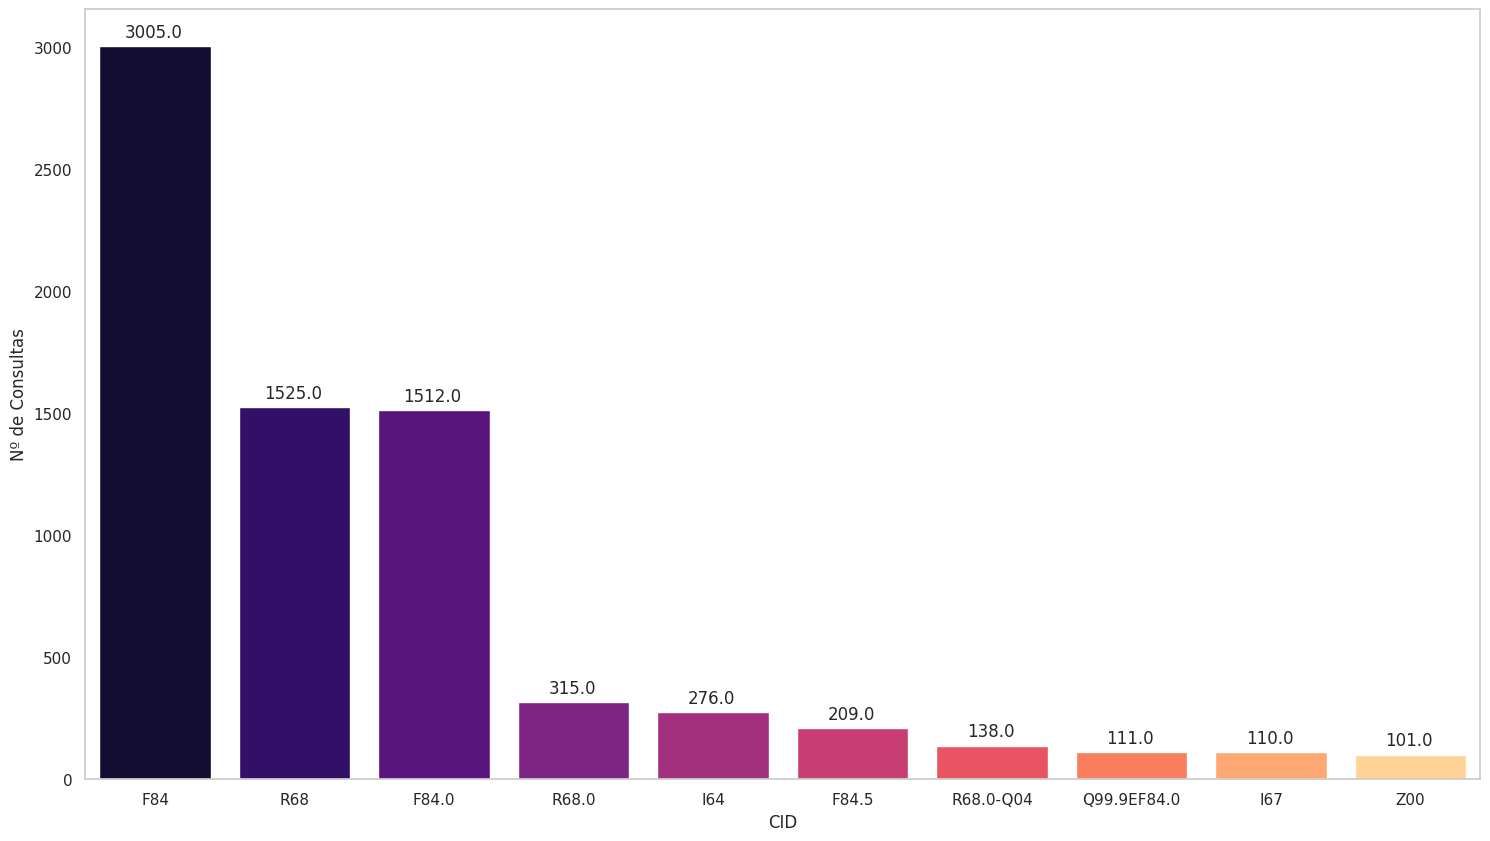

In [ ]:
plt.figure(figsize=(18,10))

sns.set_style("whitegrid", {'axes.grid' : False})

chart = sns.countplot(x='cid', data=dados_com_cid, order = dados_com_cid.cid.value_counts().head(10).index, palette="magma", saturation = 8)
chart.set(xlabel='CID', ylabel='Nº de Consultas')
chart.set_xticklabels(chart.get_xticklabels())

for p in chart.patches:
  chart.annotate(p.get_height(), (p.get_x() + p.get_width() / 20.,
                                                 p.get_height()), ha = 'center',
                                                 va = 'center', xytext = (35, 10),
                                                 textcoords = 'offset points')

### Heatmap dados nulos

<AxesSubplot: >

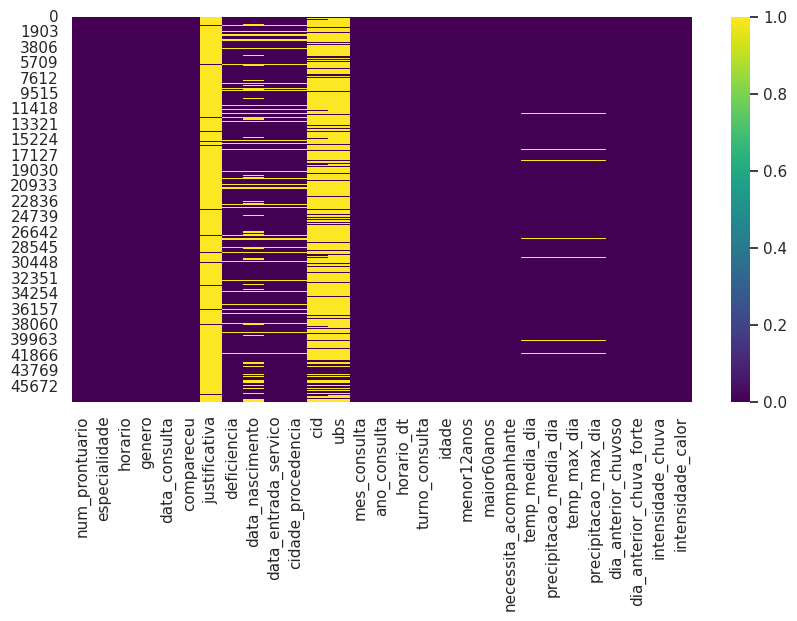

In [ ]:
plt.figure(figsize=(10,5))

sns.heatmap(dados.isnull(), cmap='viridis')

### Dados faltantes (nulos) após processamento

Incluir essa visualização ao invés do heatmap anterior (Rudimar comentou isso na apresentação)

In [ ]:
# Porcentagem dos valores faltantes por coluna

for column in dados.columns:
    if dados[column].isnull().sum() > 0:
        print(column, ': {:.2%}'.format(dados[column].isna().sum() /
                                               dados[column].shape[0]))

horario : 0.04%
compareceu : 0.10%
justificativa : 96.33%
deficiencia : 9.91%
data_nascimento : 20.47%
data_entrada_servico : 9.95%
cidade_procedencia : 9.98%
cid : 79.99%
ubs : 81.48%
horario_dt : 0.04%
temp_media_dia : 2.18%
precipitacao_media_dia : 2.18%
temp_max_dia : 2.18%
precipitacao_max_dia : 2.18%


## Dados de controle de usuários

### Criação da coluna de idade

In [ ]:
dados.columns

Index(['num_prontuario', 'especialidade', 'horario', 'genero', 'data_consulta',
       'compareceu', 'justificativa', 'deficiencia', 'data_nascimento',
       'data_entrada_servico', 'cidade_procedencia', 'cid', 'ubs',
       'mes_consulta', 'ano_consulta', 'horario_dt', 'turno_consulta'],
      dtype='object')

In [ ]:
def calcula_idade(date_of_birth):
    if (pd.isnull(date_of_birth) or date_of_birth == '' or date_of_birth == ' '): return -1

    try:
      data = datetime.strptime(date_of_birth, "%d/%m/%Y").date()
      today = date.today()
      return today.year - data.year - ((today.month, today.day) < (data.month, data.day))
    except ValueError as err:
      print('Erro ao converter a data: ' + date_of_birth)
      pass

dados['idade'] = dados['data_nascimento'].apply(calcula_idade)

In [ ]:
print("Total de registros (não pacientes) com idade incluída: %d" % len(dados[dados['idade'] > 0]))
print("Total de registros (não pacientes) com idade faltante: %d" % len(dados[dados['idade'] == -1]))

Total de registros (não pacientes) com idade incluída: 37829
Total de registros (não pacientes) com idade faltante: 9743


### Criação da coluna "é menor de 12 anos"

In [ ]:
menor12anos = dados[(dados['idade'] >= 0) & (dados['idade'] <= 12)]

print("Total de registros (não pacientes) com idade <= 12 anos: %d" % len(menor12anos))

Total de registros (não pacientes) com idade <= 12 anos: 22370


In [ ]:
def menor12anos(idade):
    if (pd.isnull(idade) or idade < 0 or idade > 12): return 0
    return 1

dados['menor12anos'] = dados['idade'].apply(menor12anos)

### Criação da coluna "é menor de 60 anos"

In [ ]:
maior60anos = dados[(dados['idade'] >= 0) & (dados['idade'] >= 60)]

print("Total de registros (não pacientes) com idade >= 60 anos: %d" % len(maior60anos))

Total de registros (não pacientes) com idade >= 60 anos: 3441


In [ ]:
def maior60anos(idade):
    if (pd.isnull(idade) or idade < 0 or idade < 60): return 0
    return 1

dados['maior60anos'] = dados['idade'].apply(maior60anos)

### Criação da coluna "necessita acompanhante"

In [ ]:
necessita_acompanhante = dados[(dados['menor12anos'] == 1) | (dados['maior60anos'] == 1)]

print("Paciente que necessitam de acompanhente: %d" % len(necessita_acompanhante))

Paciente que necessitam de acompanhente: 25811


In [ ]:
# dados['necessita_acompanhante'] = dados[(dados['menor12anos'] == 1) or (dados['maior60anos'] == 1)]

def necessita_acompanhante(x):
    if (x['menor12anos'] == 1 or x['maior60anos'] == 1): return 1
    return 0

dados['necessita_acompanhante'] = dados.apply(necessita_acompanhante, axis=1)

In [ ]:
dados[['idade', 'menor12anos', 'maior60anos', 'necessita_acompanhante']].head()

,idade,menor12anos,maior60anos,necessita_acompanhante
0,-1,0,0,0
1,-1,0,0,0
2,-1,0,0,0
3,-1,0,0,0
4,68,0,1,1


## Dados climáticos

In [ ]:
dados_clima = pd.read_csv('clima/dados_2016_2021-com-medias-e-max.csv')

In [ ]:
# Merge com dados climáticos (colunas de temperatura máxima e médica, precipitação máxima e média)
dados = pd.merge(dados, dados_clima, how='left', left_on=['data_consulta'], right_on=['data'])
dados = dados.drop(columns=['data'])

### Criação de coluna de intensidade da chuva no dia da consulta

In [ ]:
dados.dia_anterior_chuva_forte = dados.dia_anterior_chuva_forte.notna().astype(int)
dados.dia_anterior_chuvoso = dados.dia_anterior_chuvoso.notna().astype(int)

In [ ]:
def intensidade_chuva(max_precipitacao_dia):
  if (max_precipitacao_dia == ''): return ''

  if (max_precipitacao_dia > 50):    return 'muito_forte'
  elif (max_precipitacao_dia > 10):  return 'forte'
  elif (max_precipitacao_dia > 2.5): return 'moderada'
  elif (max_precipitacao_dia > 1): return 'fraca'
  return 'sem_chuva_pancadas'

dados['intensidade_chuva'] = dados.precipitacao_max_dia.apply(intensidade_chuva)

In [ ]:
dados.intensidade_chuva.value_counts()

sem_chuva_pancadas    34084
moderada               6712
fraca                  4548
forte                  2228
Name: intensidade_chuva, dtype: int64

### Criação de coluna de intensidade do calor no dia da consulta

In [ ]:
def intensidade_calor(max_temperatura_dia):
  if (max_temperatura_dia == ''): return ''

  if (max_temperatura_dia > 32):    return 'muito_calor'
  elif (max_temperatura_dia > 27):  return 'calor'
  elif (max_temperatura_dia > 22): return 'ameno'
  elif (max_temperatura_dia > 15): return 'frio'
  return 'muito_frio'

dados['intensidade_calor'] = dados.temp_max_dia.apply(intensidade_calor)

In [ ]:
dados.intensidade_calor.value_counts()

ameno          22795
frio           13705
calor           9097
muito_frio      1507
muito_calor      468
Name: intensidade_calor, dtype: int64

# Exporta dataframe

In [ ]:
dados.to_csv('dados-pre-processados.csv', index=False)

# Notas sobre o desbalanceamento

Como mostrado anteriormente, fica evidente que os modelos baseline irão ter alta assertividade devido ao fato da base estar altamente desbalanceada. Apenas 9% dos dados representam pacientes que não compareceram à consulta agendada, enquanto mais de 90% dos dados representa pacientes que compareceram. Ou seja, neste caso fica evidente que a acurácia (score do scikit learn) não é a melhor métrica para avaliar este conjunto de dados e pode levar a uma "falsa predição". Neste caso, outras métricas devem ser usadas para melhor análise do modelo construído, como: matriz de confusão, precision, recall e F1-Score.

Construir imagem semelhante traduzida para exemplificar as técnicas de oversampling e undersampling.

![Picture title](image-20221127-075422.png)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aaaff73a-c069-4671-8af2-9c3fdeaecc1c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>